In [1]:
import datetime
print('Last updated:', datetime.datetime.now(), '(PT)')

Last updated: 2020-06-17 10:29:36.420537 (PT)


In [72]:
import pystan
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../util')
from pystan_vb_extract import pystan_vb_extract
import copy

In [151]:
model = """
data {
  int<lower=0> K;  // Number of cluster
  int<lower=0> N;  // Number of observations
  real y[N];  // observations
  real<lower=0> alpha_shape;
  real<lower=0> alpha_rate;
  real<lower=0> sigma_shape;
  real<lower=0> sigma_rate;
}

parameters {
  real mu[K]; // cluster means
  // real <lower=0,upper=1> v[K - 1];  // stickbreak components
  vector<lower=0,upper=1>[K - 1] v;  // stickbreak components
  real<lower=0> sigma[K];  // error scale
  real<lower=0> alpha;  // hyper prior DP(alpha, base)
}

transformed parameters {
  simplex[K] eta;
  vector<lower=0,upper=1>[K - 1] cumprod_one_minus_v;

  cumprod_one_minus_v = exp(cumulative_sum(log1m(v)));
  eta[1] = v[1];
  eta[2:(K-1)] = v[2:(K-1)] .* cumprod_one_minus_v[1:(K-2)];
  eta[K] = cumprod_one_minus_v[K - 1];
}

model {
  real ps[K];
  // real alpha = 1;
  
  alpha ~ gamma(alpha_shape, alpha_rate);  // mean = a/b = shape/rate 
  sigma ~ gamma(sigma_shape, sigma_rate);
  mu ~ normal(0, 3);
  v ~ beta(1, alpha);

  for(i in 1:N){
    for(k in 1:K){
      ps[k] = log(eta[k]) + normal_lpdf(y[i] | mu[k], sigma[k]);
    }
    target += log_sum_exp(ps);
  }
}

generated quantities {
  real ll;
  real ps_[K];
  
  ll = 0;
  for(i in 1:N){
    for(k in 1:K){
      ps_[k] = log(eta[k]) + normal_lpdf(y[i] | mu[k], sigma[k]);
    }
    ll += log_sum_exp(ps_);
  }  
}
"""

In [152]:
# Compile the model.
%time sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc09797db5631072614538acba641227 NOW.


CPU times: user 922 ms, sys: 47.7 ms, total: 969 ms
Wall time: 49.3 s


In [206]:
# Read simulated data.
path_to_data = '../../data/sim-data/gmm-data-n200.json'
with open(path_to_data) as f:
    simdata = json.load(f)
    
# Create data dictionary.
data = dict(y=simdata['y'], K=10, N=len(simdata['y']),
            alpha_shape=1, alpha_rate=10, sigma_shape=20, sigma_rate=100)


In [207]:
def init_prior(model, data, seed=None, iter=10000, adapt_iter=1000):
    prior_data = copy.deepcopy(data)
    prior_data['y'] = []
    prior_data['N'] = 0
    prior_sample = model.vb(data=prior_data, iter=iter, seed=seed, algorithm='meanfield',
                            adapt_iter=adapt_iter, init=0, output_samples=1)
    prior_init = pystan_vb_extract(prior_sample)
    prior_init = dict([(k, prior_init[k][0]) for k in prior_init])
    return prior_init

In [209]:
# Approximate posterior via ADVI: 1.2s
# - ADVI is sensitive to starting values. Should run several times and pick run 
#   that has best fit (e.g. highest ELBO / logliklihood).
# - Variational inference works better with more data. Inference is less accurate
#   with small datasets, due to the variational approximation.

seed_ll = dict()
for seed in range(1, 21):
    prior_init = init_prior(sm, data, seed=seed)
    fit = sm.vb(data=data, iter=500, seed=seed, algorithm='meanfield', adapt_iter=100, verbose=False, init=prior_init)
    mean_loglike = pystan_vb_extract(fit)['ll'].mean()
    print("Seed: {} | Mean loglike: {}".format(seed, mean_loglike))
    seed_ll[seed] = mean_loglike

Seed: 1 | Mean loglike: -355.2286156896609


Seed: 2 | Mean loglike: -352.7359586198082


Seed: 3 | Mean loglike: -353.98144527709434


Seed: 4 | Mean loglike: -339.02710353298204


Seed: 5 | Mean loglike: -336.7831330679172


Seed: 6 | Mean loglike: -359.34929083795464


Seed: 7 | Mean loglike: -347.39508055466445


Seed: 8 | Mean loglike: -350.79080488530514


Seed: 9 | Mean loglike: -308.6156235126678


Seed: 10 | Mean loglike: -320.9665120984984


Seed: 11 | Mean loglike: -280.48960048028806


Seed: 12 | Mean loglike: -323.0460880166304


Seed: 13 | Mean loglike: -354.8771286730641


Seed: 14 | Mean loglike: -318.1960903780055


Seed: 15 | Mean loglike: -320.43410986228463


Seed: 16 | Mean loglike: -349.44788670848874


Seed: 17 | Mean loglike: -349.0152947926693


Seed: 18 | Mean loglike: -340.68880868993955


Seed: 19 | Mean loglike: -340.0344705317442


Seed: 20 | Mean loglike: -353.668666679865
CPU times: user 24.1 s, sys: 79.6 ms, total: 24.2 s
Wall time: 24.1 s


In [210]:
best_seed = sorted(seed_ll.items(), key=lambda k: k[1])[-1][0]
print('Best seed: {}'.format(best_seed))
# fit = sm.vb(data=data, iter=10000, seed=best_seed, algorithm='meanfield', adapt_iter=1000)
prior_init = init_prior(sm, data, seed=best_seed)
fit = sm.vb(data=data, iter=500, seed=best_seed, algorithm='meanfield', adapt_iter=100, verbose=False, init=prior_init)

Best seed: 11


../util/pystan_vb_extract.py:21: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])
../util/pystan_vb_extract.py:21: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])
../util/pystan_vb_extract.py:21: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])


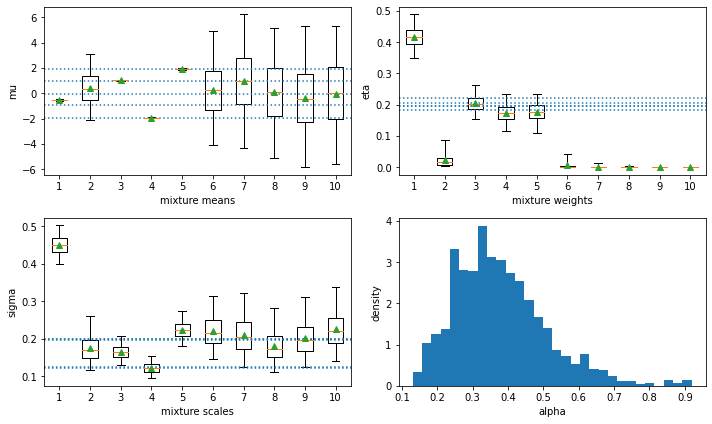

In [211]:
# Plot mu, eta
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.boxplot(pystan_vb_extract(fit)['mu'], showmeans=True, showfliers=False, whis=[2.5, 97.5]);
plt.ylabel('mu')
plt.xlabel('mixture means')
for line in simdata['mu']:
    plt.axhline(line, ls=':');
    
plt.subplot(2, 2, 2)
plt.boxplot(pystan_vb_extract(fit)['eta'], showmeans=True, showfliers=False, whis=[2.5, 97.5]);
plt.ylabel('eta')
plt.xlabel('mixture weights')
for line in simdata['w']:
    plt.axhline(line, ls=':');
    
plt.subplot(2, 2, 3)
plt.boxplot(pystan_vb_extract(fit)['sigma'], showmeans=True, showfliers=False, whis=[2.5, 97.5]);
plt.ylabel('sigma')
plt.xlabel('mixture scales')
for line in simdata['sig']:
    plt.axhline(line, ls=':');
    
plt.subplot(2, 2, 4)
plt.hist(pystan_vb_extract(fit)['alpha'], bins=30, density=True);
plt.xlabel('alpha')
plt.ylabel('density')

plt.tight_layout();

In [91]:
# MCMC setup

# Number of burn in iterations
burn = 500

# Number of sampels to keep
nsamples = 500

# Number of MCMC (HMC / NUTS) iterations in total
niters = burn + nsamples

In [98]:
%%time

# Sample from posterior via HMC: 53s
# NOTE: num_leapfrog = int_time / stepsize.
fit = sm.sampling(data=data, iter=niters, chains=1, warmup=burn, thin=1, seed=1,
                  algorithm='hmc', control=dict(stepsize=0.01, int_time=1))

CPU times: user 53.2 s, sys: 36.7 ms, total: 53.3 s
Wall time: 53.1 s


In [99]:
%%time

# Sample from posterior via NUTS: 1m 57s
fit = sm.sampling(data=data, iter=niters, chains=1, warmup=burn, thin=1, seed=1)

CPU times: user 1min 56s, sys: 159 ms, total: 1min 56s
Wall time: 1min 56s


In [109]:
def plot_param_post(samples, param_name, param_full_name, figsize=(12, 4), truth=None):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.boxplot(samples[param_name], whis=[2.5, 97.5], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=":")

    plt.subplot(1, 2, 2)
    plt.plot(samples[param_name]);
    plt.xlabel('iterations')
    plt.ylabel(param_full_name)
    plt.title('Trace plot of {}'.format(param_full_name));

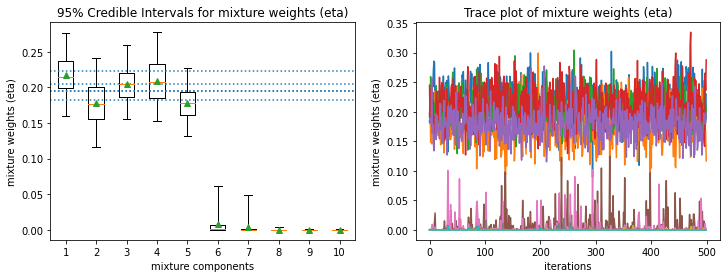

In [110]:
plot_param_post(fit, 'eta', 'mixture weights (eta)', truth=simdata['w'])

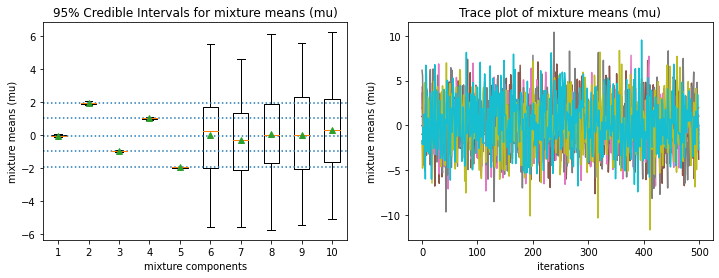

In [111]:
plot_param_post(fit, 'mu', 'mixture means (mu)', truth=simdata['mu'])

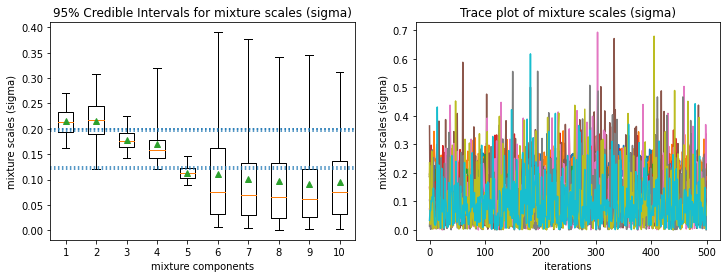

In [113]:
plot_param_post(fit, 'sigma', 'mixture scales (sigma)', truth=simdata['sig'])

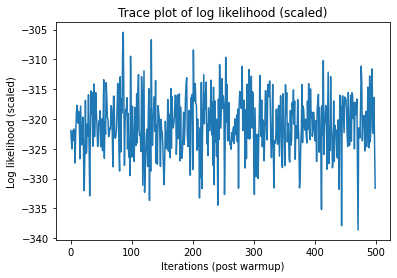

In [105]:
# Plot trace of log likelihood (up to proportionality constant)
plt.plot(fit['lp__'])
plt.xlabel("Iterations (post warmup)")
plt.ylabel("Log likelihood (scaled)");
plt.title('Trace plot of log likelihood (scaled)');

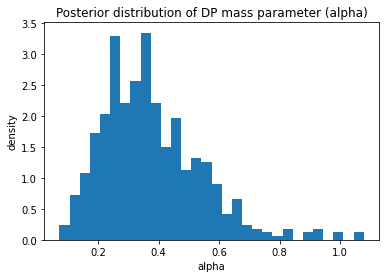

In [13]:
# Plot distribution of alpha
plt.hist(fit['alpha'], bins=30, density=True);
plt.xlabel('alpha')
plt.ylabel('density')
plt.title('Posterior distribution of DP mass parameter (alpha)');